# Un pronosticador recurrente cuantil multihorizonte

In [1]:
import pandas as pd
import numpy as np
import pathlib as plt

%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\SESA626862\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\magics\pylab.py:166: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
# PyTorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib as mplt
# PyTorch Lightning imports
import pytorch_lightning as pl

# Información del conjunto de datos a utilizar


##### Descripción
El conjunto de datos [1] no tiene valores faltantes.
Los valores están en kW de cada 15 min. Para convertir los valores en kWh, los valores deben dividirse por 4.
Cada columna representa un cliente. Algunos clientes se crearon después de 2011. En estos casos, el consumo se consideró cero.
Todas las etiquetas de tiempo informan en hora portuguesa. Sin embargo, todos los días presentan 96 medidas (24*4). 
Cada año, en el día de cambio de hora de marzo (que tiene solo 23 horas), los valores entre la 1:00 am y las 2:00 am son cero para todos los puntos. 
Cada año, en el día de cambio de hora de octubre (que tiene 25 horas), los valores entre la 1:00 am y las 2:00 am agregan el consumo de dos horas.

##### Información de la variable
El conjunto de datos se guardó como texto en formato csv, utilizando punto y coma (;).
La ​​primera columna presenta la fecha y la hora como una cadena con el siguiente formato 'aaaa-mm-dd hh:mm:ss'
Las demás columnas presentan valores flotantes con el consumo en kW

### Objetivo 

Proponemos un marco para la regresión de series temporales de múltiples pasos con probabilidad general. Específicamente, explotamos la expresividad y la naturaleza temporal de las redes neuronales de secuencia a secuencia (por ejemplo, estructuras recurrentes y convolucionales), la naturaleza no paramétrica de la regresión cuantil y la eficiencia de la predicción directa de múltiples horizontes.

Predecir 24 horas utilizando una ventana de 168 horas y 100 muestras para cada casa. Además de crear 3 variables extras

In [3]:

eldata = pd.read_csv(r"./LD2011_2014.txt",
             parse_dates=[0], ### parse dates convierte una columna en formato de date time
             delimiter=";",
             decimal=",")
eldata.rename({"Unnamed: 0": "timestamp"}, axis=1, inplace=True)
eldata.head()

,timestamp,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


El conjunto de datos contiene el consumo de electricidad de 370 clientes en kW, medido cada 15 minutos. Remuestreémoslo a un período de 1 hora:


In [4]:
eldata = eldata.resample("1h", on="timestamp").mean()

In [5]:
eldata

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
timestamp,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 04:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 20:00:00,2.220812,25.248933,1.737619,186.483740,92.073171,340.773810,11.305822,315.656566,91.783217,81.451613,...,333.511777,39700.0,1702.531646,2238.636364,74.967405,4.388531,375.768218,108.931553,688.416422,8405.405405
2014-12-31 21:00:00,2.538071,22.759602,1.737619,162.093496,86.280488,319.940476,11.588468,269.360269,76.486014,70.161290,...,327.266238,38575.0,1649.789030,1477.272727,74.967405,3.949678,465.539947,154.841402,662.023460,8283.783784
2014-12-31 22:00:00,1.903553,22.048364,1.737619,161.077236,86.890244,314.732143,11.305822,251.683502,71.678322,72.311828,...,306.209850,35475.0,1636.075949,1375.000000,64.211213,7.753072,655.179982,195.325543,679.252199,7594.594595


Dado que hay clientes cuya medición comenzó después de 2011, esperamos que algunos clientes tengan un alto porcentaje de ceros (como se documenta en la página del conjunto de datos):

Text(0, 0.5, 'porcentajes de cero')

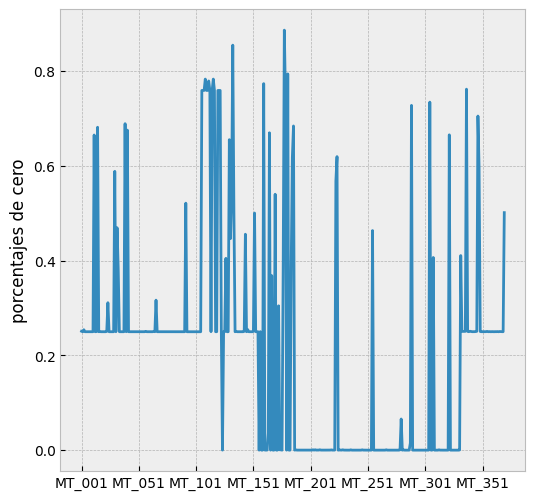

In [6]:
(eldata==0).mean().plot()
plt.ylabel("porcentajes de cero")

De hecho, podemos ver que algunos clientes tienen un bajo porcentaje de valores distintos de cero.

Para examinar cuánta variación hay entre la magnitud de los valores entre clientes, graficaremos las medianas de todos los clientes (ordenadas):

Text(0, 0.5, 'magnitude')

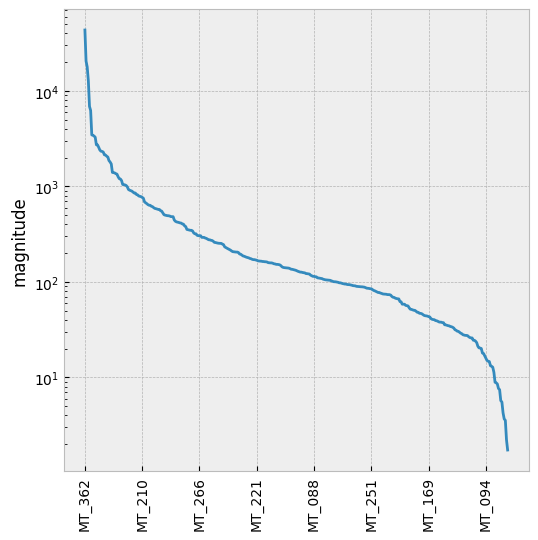

In [7]:
eldata[eldata!=0].median().sort_values(ascending=False).plot(rot=90)
plt.yscale("log")

plt.ylabel("magnitude")

Podemos ver que la mayoría de los clientes se encuentran en la región de valores de $10^2$ y $10^4$
Sin embargo, hay una diferencia de casi 5 órdenes de magnitud (!) entre la mediana mínima y la máxima, por lo que deberíamos normalizar la entrada antes de alimentar la red.

# Conjunto de datos y módulo de datos

Supongamos que el punto de tiempo aleatorio para un hogar es las 12:00 p. m. del 1 de enero.
El modelo tomará entonces las 168 horas a partir de ese punto (es decir, desde las 12:00 p. m. del 1 de enero hasta las 12:00 p. m. del 8 de enero) como la ventana de datos históricos.
Las 24 horas siguientes a esa hora (es decir, desde las 12:00 p. m. del 8 de enero hasta las 12:00 p. m. del 9 de enero) se utilizan como la ventana de pronóstico.

In [98]:
class ElectricityLoadDataset(Dataset):
    """Datos de muestra del conjunto de datos de carga eléctrica (por hogar, remuestreados a una hora)"""

    ## samples (number of samples)
    ## hist_len (history length, e.g., 168 hours for one week)
    ## fct_len (forecast length, e.g., 24 hours)
    ## offset is the length of time, e.g. 1 hour

    
    def __init__(self, df, samples, hist_len=168, fct_len=24):
        self.hist_num = hist_len
        self.fct_num = fct_len
        self.hist_len = pd.Timedelta(hours=hist_len)
        self.fct_len = pd.Timedelta(hours=fct_len)
        self.offset = pd.Timedelta(hours=1)
        self.samples = samples

        ## The dataset is filtered to remove instances beyond a certain time (self.max_ts),
        ## ensuring enough history and forecast length for valid samples. 
        self.max_ts = df.index.max() - self.hist_len - self.fct_len + self.offset ## Timestamp('2015-01-01 00:00:00') es el index maximo de eldata, el output será: Timestamp('2014-12-24 01:00:00')
        self.raw_data = df.copy()

        assert samples <= self.raw_data[:self.max_ts].shape[0]

        self.sample()

    def sample(self):
        """Tome muestras de series individuales según sea necesario."""

        # Calcular el inicio real para cada hogar, excluyendo el cero 
        self.clean_start_ts = (self.raw_data!=0).idxmax()
        #print(self.clean_start_ts)
        ## Ejemplo de output clean_start_ts
        ## MT_001   2012-01-01
        ## MT_002   2012-01-01
        ## MT_003   2012-01-01
        ## MT_004   2012-01-01
        ## continua ...
        ## eldata.iloc[8756:,0] MT_001
        ## timestamp
        ## 2011-12-31 20:00:00    0.000000
        ## 2011-12-31 21:00:00    0.000000
        ## 2011-12-31 22:00:00    0.000000
        ## 2011-12-31 23:00:00    0.000000
        ## 2012-01-01 00:00:00    3.172589 ## aqui inicia para la casa MT_001

        households = []

        for hh in self.raw_data.columns: ### son los casa
            hh_start = self.clean_start_ts[hh] ## pasa la información del i-esimo cliente, ejemplo para MT_001 hh_start seria -> 2012-01-01 00:00:00
            #print(hh_start)
            #print(hh)
            #print(self.raw_data.loc[hh_start:self.max_ts].shape)
            hh_nsamples = min(self.samples, self.raw_data.loc[hh_start:self.max_ts].shape[0]) ## es el minimo de muestras entre 100 y las que estén en el rango del tiempo que no sea 0 y el maximo
            #print(hh_nsamples)
            hh_samples = (self.raw_data
                          .loc[hh_start:self.max_ts] ## for example from 2012-01-01 00:00:00 to 2012-01-01 00:00:00 
                          .index
                          .to_series()
                          .sample(hh_nsamples, replace=False) ## de manera aleatoria y no puede tomar el valor de nuevo
                          .index) ## me quedo con el numero de muestras minimo 
            #print(hh_samples)
            #print(hh_samples.shape)
            households.extend([(hh, start_ts) for start_ts in hh_samples]) ## extend es como un append para una lista
            #print(households)
        self.samples = pd.DataFrame(households, columns=("household", "start_ts"))
        #print(self.samples)

        # Agregar características de calendario
        ## Las caracteristicas de ciclo (anual, semanal y diaria) fueron agregadas para ayudar al modelo para capturar temporadas y patrones periodicos en el uso de electricidad. 
        ## En el aspecto del ciclo anual, se intenta capturar los patrones de alto uso de electricidad como en las temporadas de verano o invierno
        ## De manera similar, los patrones de fin de semana vs semana en los ciclos semanales, o bien en el día, patrones como uso de luz mayormente en el dia y no en la noche. 

        self.raw_data["yearly_cycle"] = np.sin(2 * np.pi * self.raw_data.index.dayofyear / 366) ## el uso de la función seno mapea los valores entre -1 y 1 capturando suavemente los patrones periodicos
        self.raw_data["weekly_cycle"] = np.sin(2 * np.pi * self.raw_data.index.dayofweek / 7)
        self.raw_data["daily_cycle"] = np.sin(2 * np.pi * self.raw_data.index.hour / 24)
        self.calendar_features = ["yearly_cycle", "weekly_cycle", "daily_cycle"]

    def __len__(self):
        return self.samples.shape[0]

    def __getitem__(self, idx):
        #print(self.samples)
        household, start_ts = self.samples.iloc[idx] 
        #print(self.samples.iloc[idx])
        #print(household)
        #print(start_ts)
        #household                 MT_001
        #start_ts     2013-06-21 10:00:00

        hs, he = start_ts, start_ts + self.hist_len - self.offset  ## 168 horas 
        fs, fe = he + self.offset, he + self.fct_len ## 24 horas

        #print(hs)
        #print(he)
        hist_data = self.raw_data.loc[hs:he, [household] + self.calendar_features]
        fct_data = self.raw_data.loc[fs:fe, [household] + self.calendar_features]
        print(hist_data) #- importante quitar el comentario para ver algo en el codigo y luego comentarlo
        # scaling: 
        mean = hist_data.loc[:,household].mean()
        std = hist_data.loc[:,household].std()
        if std == 0:
            std = 1
        hist_data.loc[:,household] = (hist_data.loc[:,household] - mean) / std ## z-score normalization 
        fct_data.loc[:,household] = (fct_data.loc[:,household] - mean) / std

        return (torch.Tensor(hist_data.values),
                torch.Tensor(fct_data.values), (mean,std))
    
    ### El output de esta función consistirá de:
    ## Household: El identificador especifico del household
    ## Start Timestamp (start_ts): La fecha inicial de la ventana de historia para cada casa 
    ## Cyclical Features: 
    
    ##  - yearly cycle
    ##  - Weekly cycle
    ##  - Daily cycle

In [99]:
ds = ElectricityLoadDataset(eldata, 100)
hist, fct, (mean, std) = ds[4]
#mean, std


                       MT_001  yearly_cycle  weekly_cycle  daily_cycle
timestamp                                                             
2013-03-03 23:00:00  2.538071      0.874481     -0.781831    -0.258819
2013-03-04 00:00:00  2.220812      0.882679      0.000000     0.000000
2013-03-04 01:00:00  2.220812      0.882679      0.000000     0.258819
2013-03-04 02:00:00  2.220812      0.882679      0.000000     0.500000
2013-03-04 03:00:00  2.220812      0.882679      0.000000     0.707107
...                       ...           ...           ...          ...
2013-03-10 18:00:00  1.586294      0.926324     -0.781831    -1.000000
2013-03-10 19:00:00  1.586294      0.926324     -0.781831    -0.965926
2013-03-10 20:00:00  1.903553      0.926324     -0.781831    -0.866025
2013-03-10 21:00:00  1.903553      0.926324     -0.781831    -0.707107
2013-03-10 22:00:00  1.586294      0.926324     -0.781831    -0.500000

[168 rows x 4 columns]


In [96]:
hist

tensor([[-4.1110e-01,  1.5389e-01, -7.8183e-01, -5.0000e-01],
        [-4.1110e-01,  1.5389e-01, -7.8183e-01, -7.0711e-01],
        [-4.1110e-01,  1.5389e-01, -7.8183e-01, -8.6603e-01],
        [-5.2376e-01,  1.5389e-01, -7.8183e-01, -9.6593e-01],
        [-4.1110e-01,  1.5389e-01, -7.8183e-01, -1.0000e+00],
        [-2.9843e-01,  1.5389e-01, -7.8183e-01, -9.6593e-01],
        [-4.1110e-01,  1.5389e-01, -7.8183e-01, -8.6603e-01],
        [-1.8576e-01,  1.5389e-01, -7.8183e-01, -7.0711e-01],
        [ 3.7756e-01,  1.5389e-01, -7.8183e-01, -5.0000e-01],
        [ 8.2823e-01,  1.5389e-01, -7.8183e-01, -2.5882e-01],
        [ 1.5223e-01,  1.3691e-01,  0.0000e+00,  0.0000e+00],
        [-7.3099e-02,  1.3691e-01,  0.0000e+00,  2.5882e-01],
        [-7.3099e-02,  1.3691e-01,  0.0000e+00,  5.0000e-01],
        [-7.3099e-02,  1.3691e-01,  0.0000e+00,  7.0711e-01],
        [ 3.9567e-02,  1.3691e-01,  0.0000e+00,  8.6603e-01],
        [-7.3099e-02,  1.3691e-01,  0.0000e+00,  9.6593e-01],
        

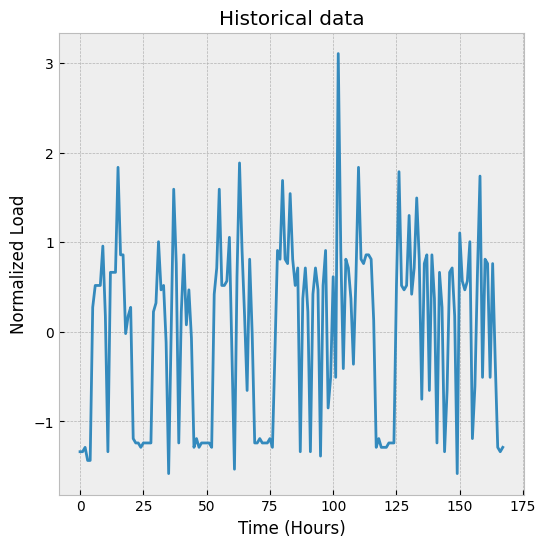

In [19]:
import matplotlib.pyplot as plt
hist_array = hist[:,0].numpy()
plt.plot(hist_array)
plt.title("Historical data")
plt.xlabel("Time (Hours)")
plt.ylabel("Normalized Load")
plt.show()

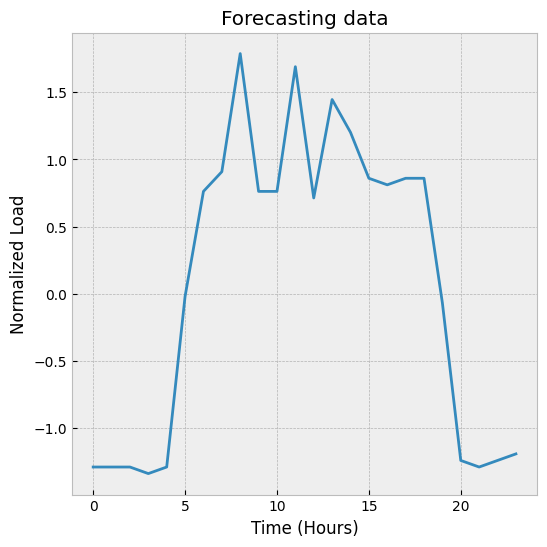

In [20]:
fc_array = fct[:,0].numpy()
plt.plot(fc_array)
plt.title("Forecasting data")
plt.xlabel("Time (Hours)")
plt.ylabel("Normalized Load")
plt.show()

Compruebe la longitud correcta

In [21]:
hist.shape

torch.Size([168, 4])

In [22]:
fct.shape

torch.Size([24, 4])

Compruebe el numero de muestras por casa (son 100 muestras por casa)

In [23]:
ds.samples

,household,start_ts
0,MT_001,2014-11-23 12:00:00
1,MT_001,2013-09-04 09:00:00
2,MT_001,2012-02-20 22:00:00
3,MT_001,2013-01-01 02:00:00
4,MT_001,2012-01-07 03:00:00
...,...,...
36995,MT_370,2013-11-21 11:00:00
36996,MT_370,2013-07-03 21:00:00
36997,MT_370,2013-11-03 00:00:00
36998,MT_370,2014-04-12 00:00:00


In [24]:
ds.samples.groupby("household").size().unique()

array([100], dtype=int64)

Como lo esperado, tenemos 100 muestras por cliente


# Verificar la exactitud de los datos
Verificamos la exactitud comparando los datos que obtenemos del cargador de conjuntos de datos con los datos brutos correspondientes. Para ello, primero obtenemos el hogar y la marca de tiempo de inicio del atributo samples para el mismo índice que muestreamos anteriormente para obtener hist, fct y (mean, std) y obtener los datos correspondientes directamente del marco de datos:

In [25]:
household, start_ts = ds.samples.iloc[4]
eldata.loc[start_ts:,household].head()

timestamp
2012-01-07 03:00:00    4.124365
2012-01-07 04:00:00    4.124365
2012-01-07 05:00:00    4.441624
2012-01-07 06:00:00    3.489848
2012-01-07 07:00:00    3.489848
Freq: h, Name: MT_001, dtype: float64

In [26]:
eldata.loc[start_ts+pd.Timedelta(days=7):,household].head()

timestamp
2012-01-14 03:00:00    4.441624
2012-01-14 04:00:00    4.441624
2012-01-14 05:00:00    4.441624
2012-01-14 06:00:00    4.124365
2012-01-14 07:00:00    4.441624
Freq: h, Name: MT_001, dtype: float64

Ahora, comparando lo anterior con los datos no normalizados que obtuvimos del cargador de conjuntos de datos:

In [27]:
hist[:,0]*std +mean, fct[:,0]*std + mean

(tensor([ 4.1244,  4.1244,  4.4416,  3.4898,  3.4898, 14.5939, 16.1802, 16.1802,
         16.1802, 19.0355, 13.9594,  4.1244, 17.1320, 17.1320, 17.1320, 24.7462,
         18.4010, 18.4010, 12.6904, 13.9594, 14.5939,  5.0761,  4.7589,  4.7589,
          4.4416,  4.7589,  4.7589,  4.7589,  4.7589, 14.2766, 14.9112, 19.3528,
         15.8629, 16.1802, 12.0558,  2.5381, 13.0076, 23.1599, 17.7665,  4.7589,
         14.2766, 18.4010, 13.3249, 15.8629, 12.3731,  4.4416,  5.0761,  4.4416,
          4.7589,  4.7589,  4.7589,  4.7589,  4.4416, 15.5457, 17.4492, 23.1599,
         16.1802, 16.1802, 16.4975, 19.6701, 11.1041,  2.8553, 16.8147, 25.0635,
         18.7183, 13.9594,  8.5660, 18.0838, 12.6904,  4.7589,  4.7589,  5.0761,
          4.7589,  4.7589,  4.7589,  5.0761,  4.4416, 11.4213, 18.7183, 18.0838,
         23.7944, 18.0838, 17.7665, 22.8426, 18.0838, 16.1802, 17.4492,  4.1244,
         15.2284, 17.4492, 14.2766,  4.1244, 15.5457, 17.4492, 15.8629,  3.8071,
         16.1802, 18.7183,  

Vemos que los datos son idénticos, como se esperaba.

# Módulo de datos

In [28]:
class ElectricityLoadDataModule(pl.LightningDataModule):
    """DataModule for electricity data."""

    def __init__(self, df, train=0.7,val=0.2, test=0.1, samples=100, batch_size=64, workers=3):
        super().__init__()
        
        assert train + val + test <= 1

        self.raw_data = df ## shape = (35065, 370)
        self.train_size = int(train * df.shape[1]) ## 259
        self.val_size = int(val * df.shape[1]) # 370*.20
        self.test_size = df.shape[1] - self.train_size - self.val_size

        self.samples = samples
        self.batch_size = batch_size
        self.workers = workers
        self.split()

    def split(self):
        hh_rand = (self.raw_data
                   .columns
                   .to_series()
                   .sample(self.raw_data.shape[1],
                           replace=False)) ## es para revolver las casas los MT
        

        ###1. MT_080
        ###2. MT_002
        #.
        #.
        #.

        self.train_hh = hh_rand.iloc[:self.train_size].index
        self.val_hh = hh_rand.iloc[self.train_size:(self.val_size + self.train_size)].index
        self.test_hh = hh_rand.iloc[-self.test_size:].index

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            train_df = self.raw_data[self.train_hh]
            val_df = self.raw_data[self.val_hh]

            self.train_ds = ElectricityLoadDataset(train_df,
                                                   samples=self.samples)
            self.val_ds = ElectricityLoadDataset(val_df,
                                                 samples=self.samples)

        if stage == "test" or stage is None:
            test_df = self.raw_data[self.test_hh]
            self.test_ds = ElectricityLoadDataset(test_df,
                                              samples=self.samples)

    
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.workers, shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.workers, shuffle=True)
    

In [29]:
# dm = ElectricityLoadDataModule(eldata)
dm = ElectricityLoadDataModule(eldata, workers=0)
dm.setup()

Verifique que el conjunto de entrenamiento no se superponga con los conjuntos val o test y que todos sumen 370:

In [30]:
assert dm.train_hh.intersection(dm.val_hh).empty
assert dm.train_hh.intersection(dm.test_hh).empty
assert dm.train_hh.size + dm.val_hh.size + dm.test_hh.size == 370

Realizar algunas pruebas en un lote de entrenamiento muestreado:

In [39]:
x, y, (mean, std) = next(iter(dm.train_dataloader()))
x.shape, y.shape

(torch.Size([64, 168, 4]), torch.Size([64, 24, 4]))

In [32]:
mean

12.816881194102004

In [33]:
std

6.498918257325191

In [34]:
dm.test_ds.samples

,household,start_ts
0,MT_245,2013-05-07 15:00:00
1,MT_245,2014-06-21 21:00:00
2,MT_245,2012-07-01 21:00:00
3,MT_245,2014-02-03 01:00:00
4,MT_245,2014-10-25 21:00:00
...,...,...
3695,MT_317,2012-01-26 07:00:00
3696,MT_317,2014-08-11 00:00:00
3697,MT_317,2014-02-25 14:00:00
3698,MT_317,2012-07-30 09:00:00


De hecho, dado que la prueba es del 10% de los datos = 37 hogares, y muestreamos cada hogar 100 veces, obtenemos el número total esperado de muestras: 3700.

# Modelo

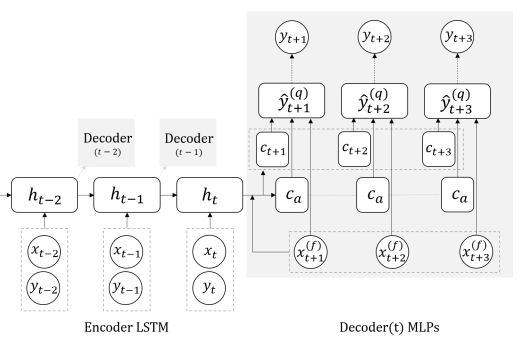

In [75]:
class ElectricityModel(pl.LightningModule):
    """Encoder network for MQ-RNN forecast model."""

    def __init__(self, hist_len=168, fct_len=24, input_size=4, num_layers=1, hidden_units=8, ct_size=8, ca_size=8,
                 quantiles=[0.1,0.5,0.9], min_hist_len = 120, lr=1e-3):
        super().__init__()
        self.hist_len = hist_len
        self.fct_len = fct_len
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_units = hidden_units
        self.ct_size = ct_size ## Contextos especificos por horizonte: Captura información relevante para cada punto futuro especifico
        self.ca_size = ca_size ## Contexto independiente del horizonte: Captura información común a todos los horizontes futuros
        self.quantiles = quantiles
        self.n_quantiles = len(quantiles)
        self.min_hist_len = min_hist_len
        self.lr = lr
        ### Esto tiene un diseño lógico basado  en como se combinan las caracteristicas temporales y futuras
        self.global_in_features = hidden_units + fct_len * (input_size - 1) #136 ## se resta uno porque este modelo asume que una de las caracteristicas de entrada es la variable objetivo (es decir, el valor que se quiere predecir)
        self.global_out_features = ca_size + fct_len * ct_size # para ello todos los horizontes comparten un contexto general de 64, y cada horizonte de los datos conocidos a predecir tiene su propio contexto espeficico de tamaño ct
        self.local_in_features = ca_size + ct_size + input_size-1 #  es la combinación de los contextos con las caracteristicas que se utilizan para predecir los multihorizontes

        self.encoder = nn.LSTM(input_size=self.input_size,
                               hidden_size=self.hidden_units,
                               num_layers=self.num_layers,
                               batch_first=True)
        self.global_mlp = nn.Linear(in_features= self.global_in_features, out_features=self.global_out_features) 
        self.local_mlp = nn.Linear(in_features=self.local_in_features, out_features=self.n_quantiles) 

    def forward(self, x, x_f, hidden=None):

        #x_f es el forecasting 
        _, (hn, cn) = self.encoder(x, hidden) # pasamos los datos historicos sobre un LSTM (hn es el hidden state al final del time step y cn es la celda para capturar and retener las dependencias largas en los datos secuenciales)
        #print(hn.shape) ## muestra el rango del batch - El batch dividirá los datos en batches de X cantidad definida por ti - esto lo verán despues en el curso pero es para optimizar la convergencia del modelo
 
        hn_s = hn.squeeze() # removemos la dimensión extra 
        #print(hn_s.shape)
        x_f_vec = x_f.reshape(-1, x_f.shape[1] * x_f.shape[2]) # sigue como un tensor y mejor hacemos un aplanado de dimensiones de las covariables
        global_input = torch.cat([x_f_vec,hn_s], dim=1) ## concatenamos las covariables ya aplanadas con el hiden state, el cual será el input para el global MLP
        #print(global_input.shape)
        contexts = self.global_mlp(global_input) # (batch_size, ca_size + fct_len * ct_size) - pasamos el global input en el modelo de MLP para aprender los contextos CA Y CT
        #print(contexts.shape) - 448
        #print(contexts)
        ca = contexts[:,self.ca_size:].reshape(-1, self.fct_len, self.ct_size) #64
        ct = contexts[:,:self.ca_size].view(-1, 1, self.ca_size).expand(-1,self.fct_len,-1) #24*16 = 384 - los primeros 384
        local_input = torch.cat([ct,ca,x_f],dim=2) # to get (batch_size, fct_len, ca_size + ct_size + input_size - 1) size ## concatenamos el contexto global, contexto local y las covariables
        y_hat = self.local_mlp(local_input) # (barch_size, fct_len, n_quantiles) ## predecimos los valores de quantiles para cada time step en el horizonte del forecasting
        
        return y_hat, hn, cn
    def training_step(self, batch, batch_idx):
        
        x, y, _ = batch ## x es el dato historico, y son los valores a predecir que son los forecast values
        x_cat = torch.cat([x, y], dim=1) ## concatenamos x con y 
        
        # first forward on min_hist_len to get the hidden states and compute the corresponding loss
        y_hat, hn, cn = self(x_cat[:, :self.min_hist_len, :], x_cat[:, self.min_hist_len:self.min_hist_len+self.fct_len, 1:])
        loss = self.loss(y_hat, x_cat[:, self.min_hist_len:self.min_hist_len+self.fct_len, [0]])
        
        # forking-sequences implementation: we move on the hist. series one by one and forecast for the next <fct_len>, 
        # then add the current loss to the aggregated one
        for i in range(self.min_hist_len,self.hist_len):
            y_hat, hn, cn = self(x_cat[:, i:i+1, :], x_cat[:, i+1:i+1+self.fct_len, 1:], (hn, cn))
            loss += self.loss(y_hat, x_cat[:, i+1:i+1+self.fct_len, [0]])
        
        return loss / (self.hist_len - self.min_hist_len + 1)
            
    def validation_step(self, batch, batch_idx):
        # we need to validate only on full length series (and not perform forking-sequences as in the training)
        x, y, _ = batch
        
        y_hat, hn, cn = self(x, y[:, :, 1:])
        loss = self.loss(y_hat, y[:, :, [0]])

        self.log('val_QL', loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def loss(self, y_hat, y):
        # y, y_hat and self.quantiles need to be broadcastable: https://pytorch.org/docs/stable/notes/broadcasting.html
        # usually y: (batch_size, fct_len, 1), y_hat: (batch_size,fct_len,self.n_quantiles), quantiles: (self.n_quantiles)
        zeros = torch.zeros_like(y_hat)
        quantiles = torch.tensor(self.quantiles,device=y.device)
        error = y - y_hat
        return torch.mean(quantiles * torch.maximum(error, zeros) + (1 - quantiles) * torch.maximum(-error, zeros))   

# Prueba del modelo Electricity

In [78]:
dm = ElectricityLoadDataModule(eldata, batch_size=128, workers=0)
model = ElectricityModel(lr=1e-3, hidden_units=64, ca_size = 64, ct_size = 16, num_layers=1)
dm.setup()
batch = next(iter(dm.train_dataloader()))
# batch = next(iter(dm.test_dataloader()))
X, y, (mean, std) = batch

y_hat, _, _ = model.forward(X, y[:,:,1:])
y_hat.shape

torch.Size([128, 24, 3])

Como se esperaba, la longitud de la secuencia de salida es 24 y su tamaño es 3, como el número de cuantiles (esos 2 parámetros, por supuesto, se pueden cambiar en la inicialización del modelo).

Pruebe que el paso de entrenamiento se ejecuta sin errores:

In [79]:
model.training_step(batch, 0)

tensor(0.4285, grad_fn=<DivBackward0>)

# Entrenamiento

In [83]:
# dm = ElectricityLoadDataModule(scaled_data, batch_size=128, workers=0)
dm = ElectricityLoadDataModule(eldata, batch_size=128, workers=0)
model = ElectricityModel(lr=1e-3, hidden_units=64, ca_size = 64, ct_size = 16, quantiles = [0.01,0.1,0.5,0.9,0.99],
                         num_layers=1)
trainer = pl.Trainer(max_epochs=2)
#trainer = pl.Trainer(max_epochs=5, progress_bar_refresh_rate=1, accelerator='ddp_cpu')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [84]:
trainer.fit(model, dm)

Epoch 0:  15%|█▌        | 31/203 [00:44<04:04,  0.70it/s, v_num=5]



  | Name       | Type   | Params | Mode 
----------------------------------------------
0 | encoder    | LSTM   | 17.9 K | train
1 | global_mlp | Linear | 61.4 K | train
2 | local_mlp  | Linear | 420    | train
----------------------------------------------
79.7 K    Trainable params
0         Non-trainable params
79.7 K    Total params
0.319     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\SESA626862\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\SESA626862\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


c:\Users\SESA626862\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 203/203 [02:32<00:00,  1.33it/s, v_num=6, val_QL=0.0816]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 203/203 [02:32<00:00,  1.33it/s, v_num=6, val_QL=0.0816]


In [85]:
dm.setup(stage="test")
batch = next(iter(dm.test_dataloader()))
X, y, (mean, std) = batch
X.shape

torch.Size([128, 168, 4])

In [86]:
result = model(X, y[:,:,1:])
result[0].shape

torch.Size([128, 24, 5])

In [87]:
std.shape

torch.Size([128])

In [88]:
res = result[0]*std.view(-1,1,1) + mean.view(-1,1,1)
x = X[:,:,0]*std.view(-1,1) + mean.view(-1,1)
y = y[:,:,0]*std.view(-1,1) + mean.view(-1,1)

res = res.cpu().detach().numpy()
x = x.cpu().detach().numpy()
y = y.cpu().detach().numpy()

quantiles_num = len(model.quantiles)
half = (quantiles_num - 1) // 2
res.shape

(128, 24, 5)

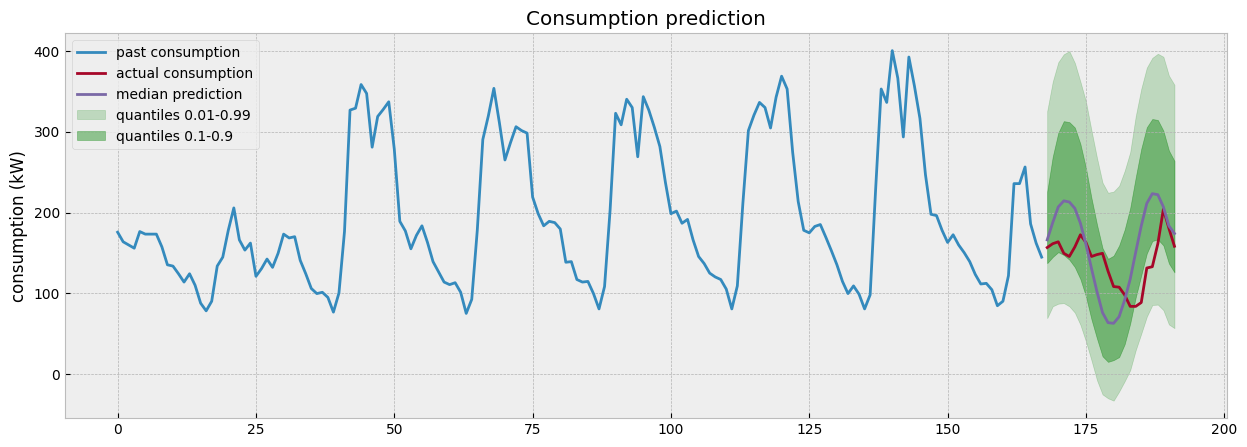

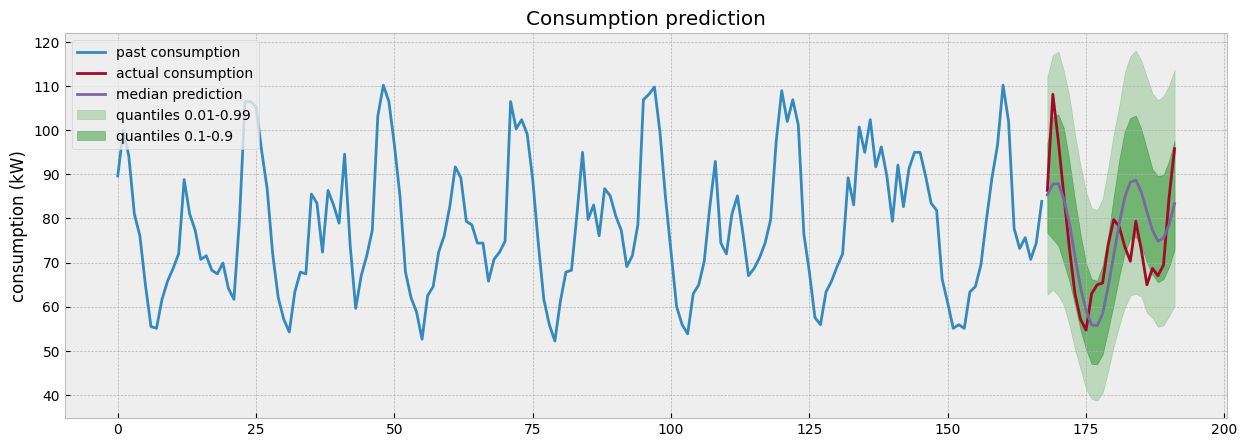

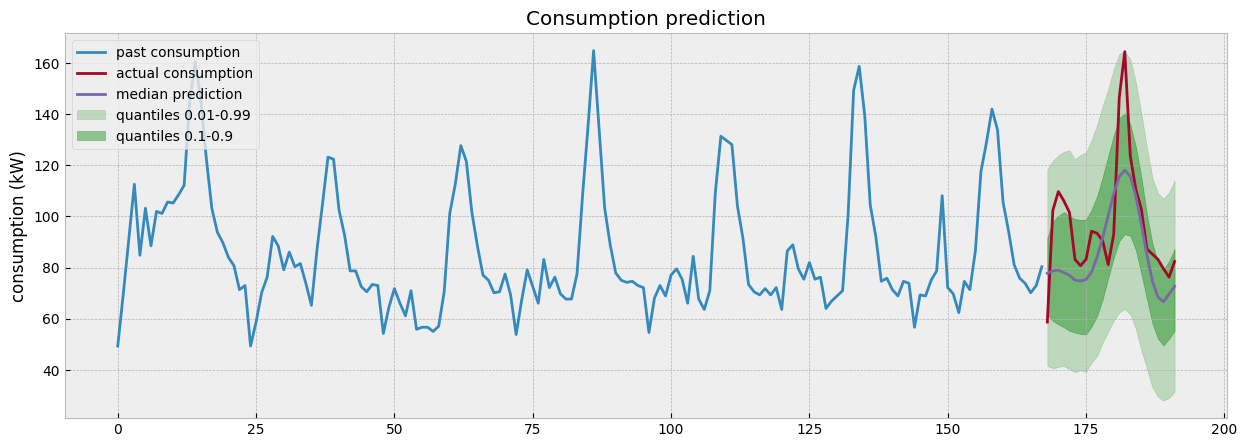

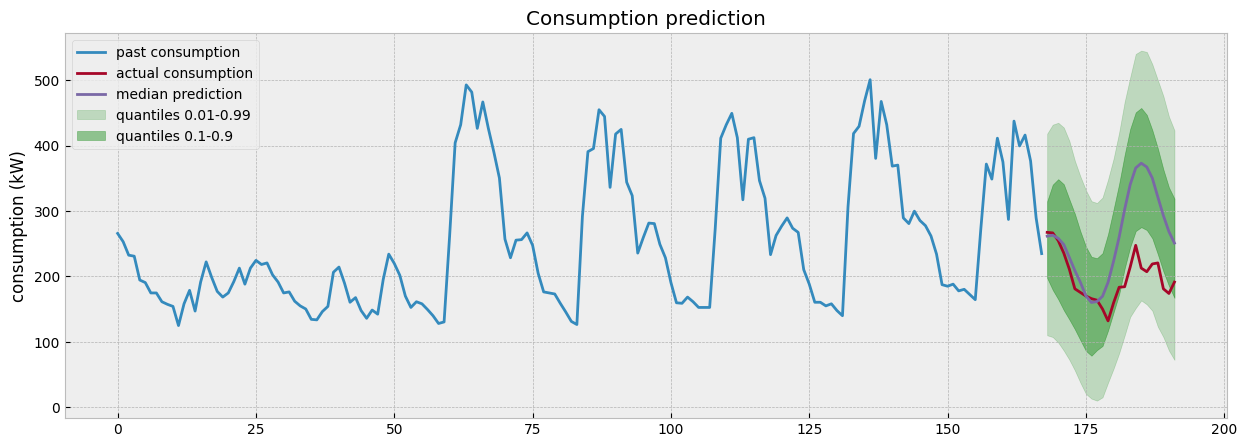

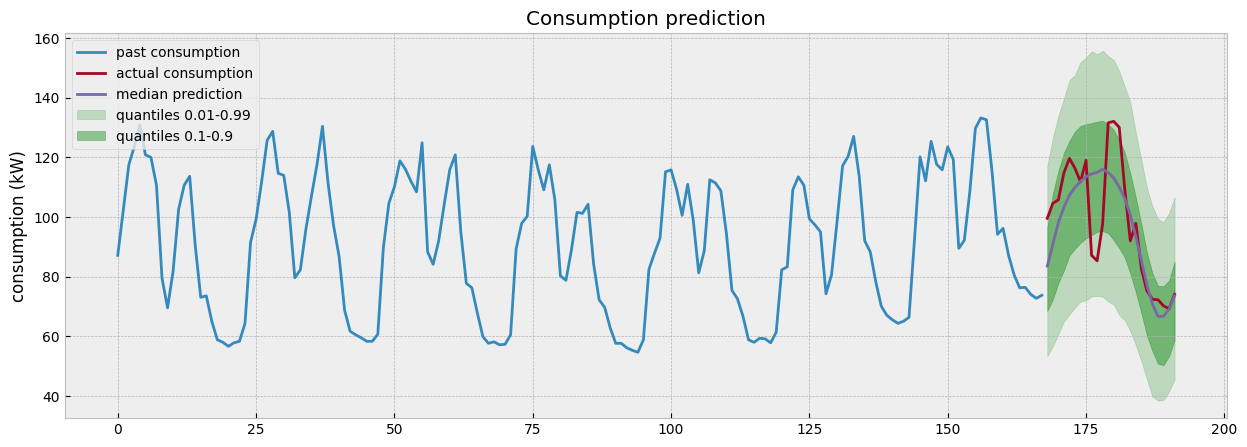

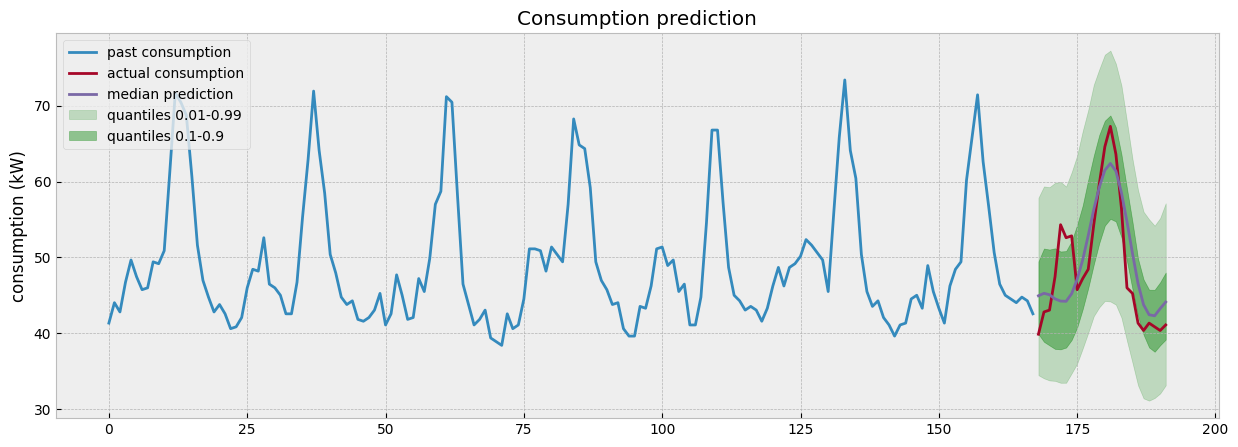

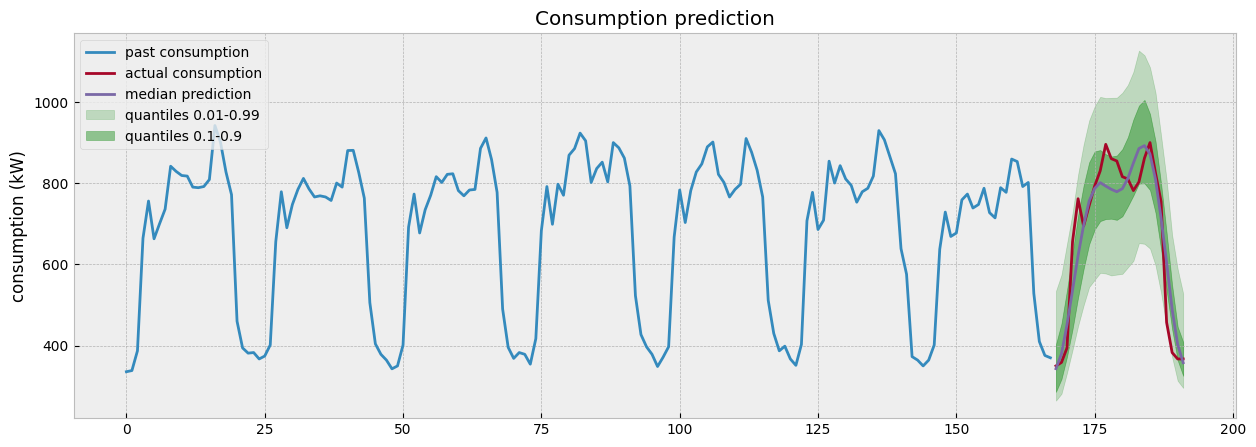

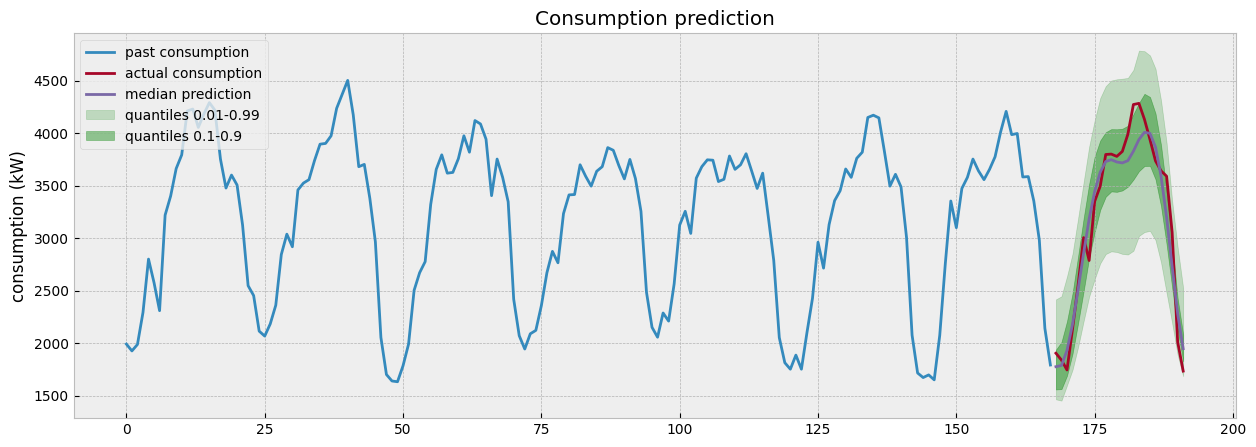

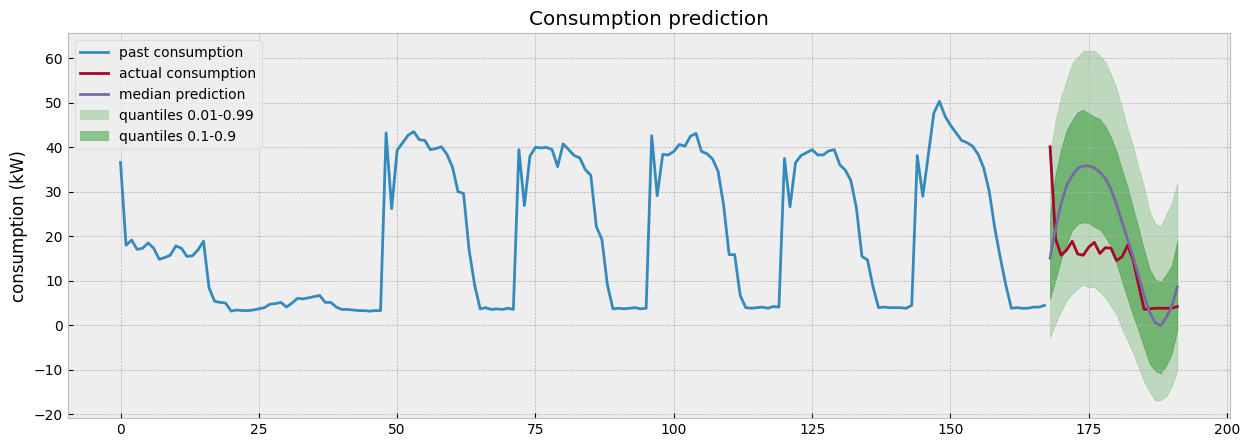

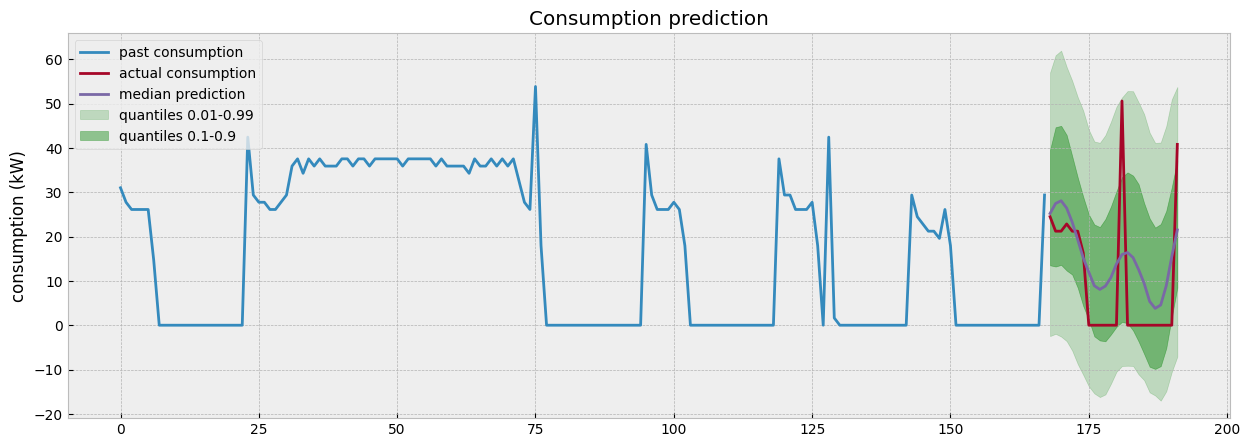

In [89]:
samples = np.random.randint(res.shape[0],size=10)

for n in samples:
    fig = plt.figure(figsize=(15,5))
    plt.title("Consumption prediction")
    plt.plot(x[n,:], label="past consumption")
    plt.plot(np.arange(168, 192, 1), y[n, :], label="actual consumption")
    plt.plot(np.arange(168, 192, 1), res[n, :, half], label="median prediction")
    # res = res[:, 1:]
    for i in range(half):
        alph = 0.0 + (i + 1)/ quantiles_num
        plt.fill_between(np.arange(168, 192, 1), res[n, :, i], res[n, :, -(i + 1)],
                         color="g", alpha=alph, label=f"quantiles {model.quantiles[i]}-{model.quantiles[-(i + 1)]}")

    plt.legend(loc="upper left")
    # plt.grid()
    # plt.tight_layout()
    plt.ylabel("consumption (kW)")
    plt.show()

# Referencias 

1. https://archive.ics.uci.edu/dataset/321/electricityloaddiagrams20112014
2. https://arxiv.org/pdf/1711.11053